# Import the necessary modules

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.constraints import maxnorm

pyplot.rcParams['figure.figsize'] = [15, 35]

Using TensorFlow backend.


# Collect and analyze the data

Before making any decisions as to what strategy to follow to make predictive models, it is important to take a careful look at the available data.
In this exercise, a bit of preprocessing needed to be done (replacing spaces with comas) in order obtain csv-readable files.

In [2]:
# Load data from files and create the correspoding pandas DataFrames
in_training_df = read_csv('input.training.txt', header=0)
in_test_df = read_csv('input.test.txt', header=0)
out_training_df = read_csv('output.training.txt', header=0)
out_test_df = read_csv('output.test.txt', header=0)

To begin with, let's verify the input variables. Graphic visualization is essential to make sure everything is in it's right place

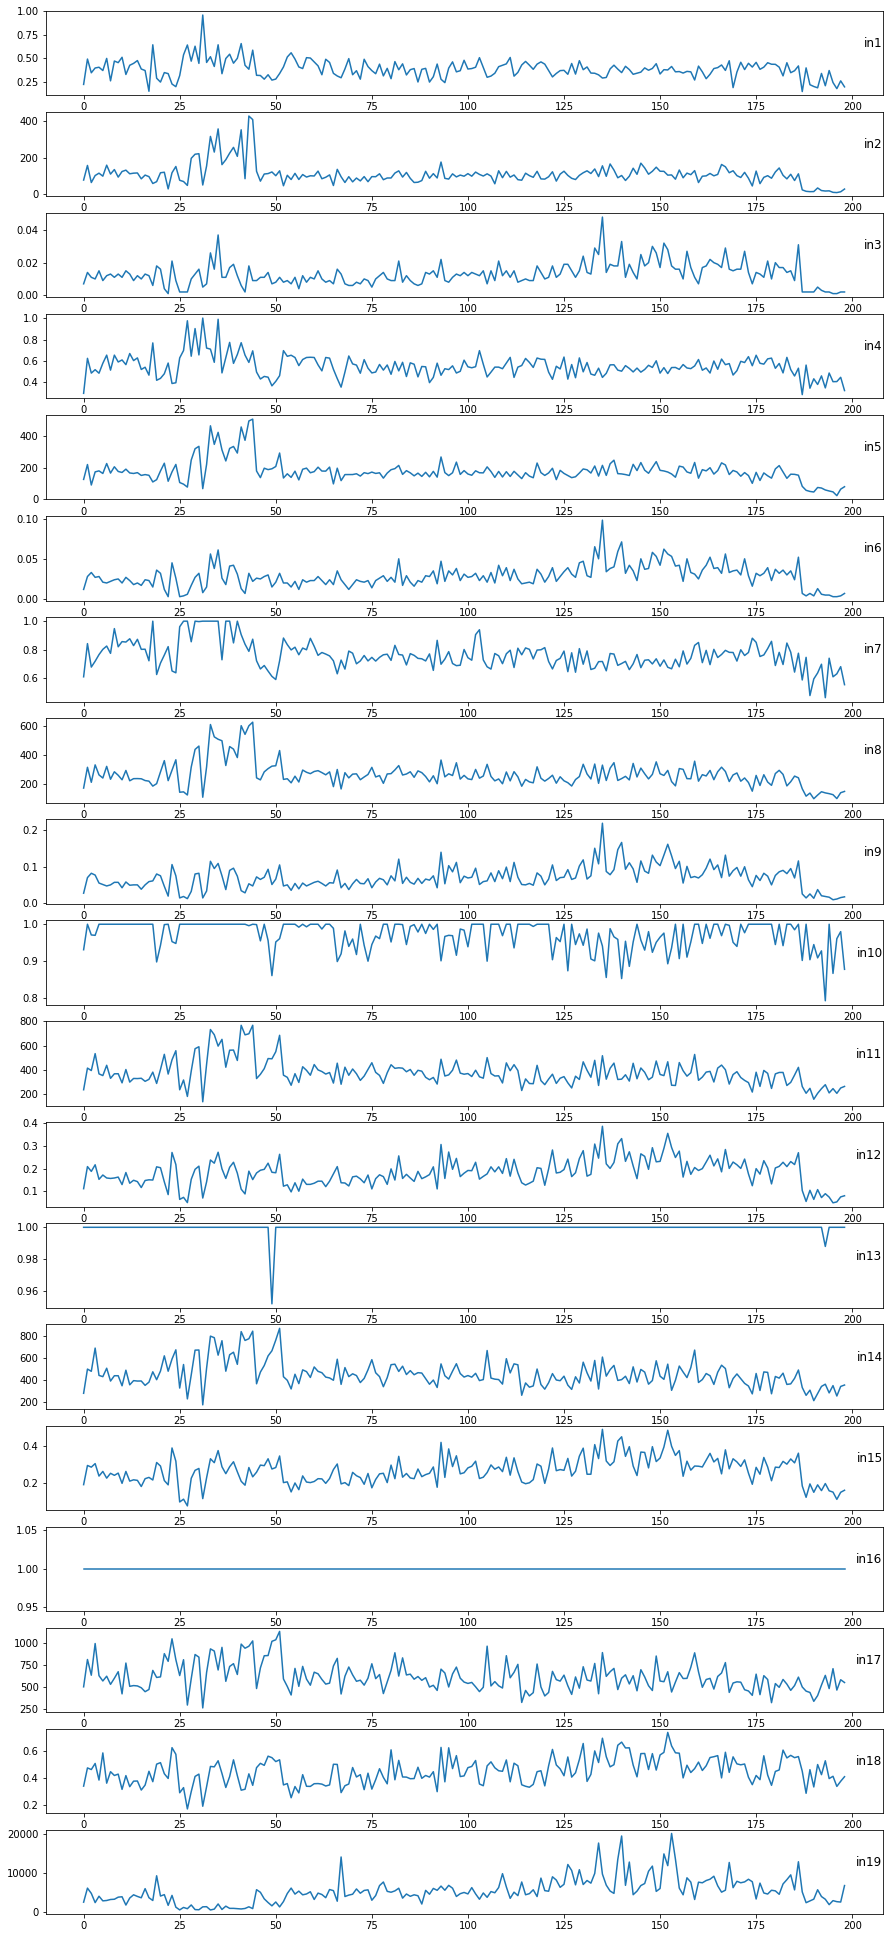

In [7]:
# Specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(in_training_df.values[:, group])
    pyplot.title(in_training_df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

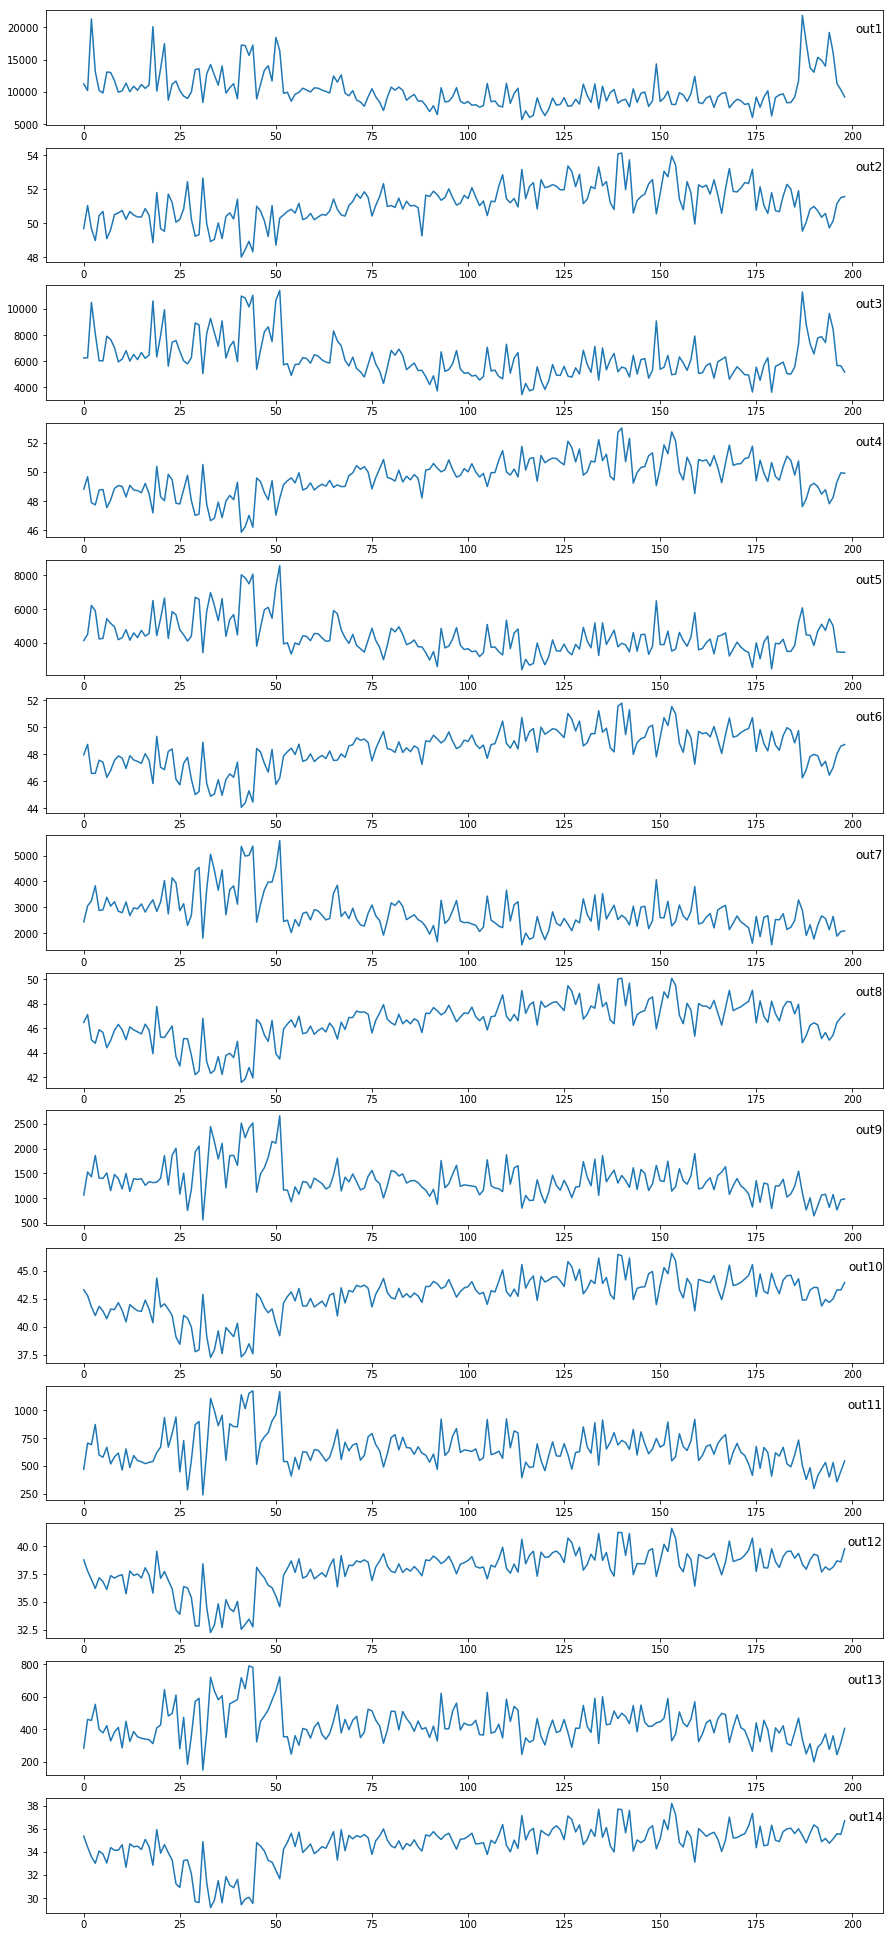

In [8]:
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(out_training_df.values[:, group])
    pyplot.title(out_training_df.columns[group], y=0.75, loc='right')
    i += 1
pyplot.show()

# Choice of prediction method

Observing the provided data set and charts above, and after the different informations gathered in meetings, it seems like we are facing a typical multivariate time series problem. There is a number of possible options on how to tackle the problem, of which just two came immediately to my head:


### ARIMA Model

The gold standard for this kind of problems is ARIMA model. The core idea behind ARIMA is to break the time series into different components such as trend component, seasonality component etc and carefully estimate a model for each component. See Using R for Time Series Analysis for a good overview.

However, ARIMA has an unfortunate problem. It needs an expert ( a good statistics degree or a grad student) to calibrate the model parameters. If you want to do multivariate ARIMA, that is to factor in multiple fields, then things get even harder.

### LSTM Networks

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people afterwards.
They work very well on a large variety of problems, and are now widely used.

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.
Nevertheless, Keras enables us to use them with a simple call in the construction of the model.

Coincidentally, as part of my current research in cryptocurrencies I am applying RNNs to try to forecast the price of different coin pairs. 
This notebook was made as a quick "refrito" of my work-on-progress where instead of financial technical indicators of different coins from exchanges we have a sequence of different values of several features.

My previous results were fairly satisfactory, so I thought it might be worth giving it a shot.

# 1.-Data preparation and normalization

It is always beneficial to normalize training data. Having different features with widely different scales fed to the model will cause the network to weight features not equally. This can cause a falsely prioritisation of some features over the others in the representation.

We will be using a MinMaxScaler from the sklearn library. 

This estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one.

In [9]:
# We have to extract the values from the data frame to operate with them. 
in_training_values = in_training_df.values
in_test_values = in_test_df.values
out_training_values = out_training_df.values
out_test_values = out_test_df.values

# Normalize features and ensure all data is float.The MinMaxScaler is fed with a numpy.ndarray 
# obtained from the respective dataframe 
scaler = MinMaxScaler(feature_range=(0, 1))
in_training_values = scaler.fit_transform(in_training_values).astype('float32')
in_test_values = scaler.fit_transform(in_test_values).astype('float32')
out_training_values = scaler.fit_transform(out_training_values).astype('float32')
out_test_values = scaler.fit_transform(out_test_values).astype('float32')

# Reshape input to be 3D [samples, timesteps, features], so that the LSTM layer can be included in the model
in_training_values = in_training_values.reshape((in_training_values.shape[0], 1, in_training_values.shape[1]))
in_test_values = in_test_values.reshape((in_test_values.shape[0], 1, in_test_values.shape[1]))

# Output the shapes
print(in_training_values.shape, out_training_values.shape, in_test_values.shape, out_test_values.shape)

#Change the size of subsequent charts to make them easier to visualize
pyplot.rcParams['figure.figsize'] = [15, 5]

(199, 1, 19) (199, 14) (128, 1, 19) (128, 14)


# 2.-Define and fit models

We will be using Keras over Tensorflow.

From their official webpage:

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. 

It was developed with a focus on enabling fast experimentation. 

Being able to go from idea to result with the least possible delay is key to doing good research.

Use Keras if you need a deep learning library that:

    Allows for easy and fast prototyping (through user friendliness, modularity, and extensibility).
    Supports both convolutional networks and recurrent networks, as well as combinations of the two.
    Runs seamlessly on CPU and GPU.

Yep, seems like Keras is just for us! :D

Ok, we won't be using GPU this time, bit still...


## Experiment #1: Stochastic Gradient Descent Optimizer

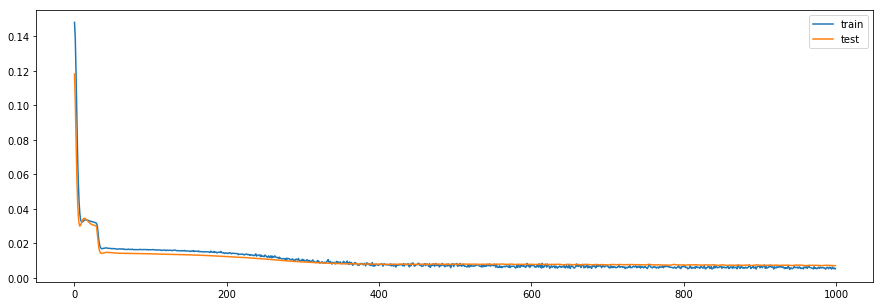

In [29]:
# The design of the network stacks an LSTM (RNN) layer on top of a dropout and a fully connected layers.
# The addition of dropoutlayers in known to help with overfitting problems likethe ones encountered
# during hyperparameter tuning 
sgd_model = Sequential()
sgd_model.add(LSTM(5, input_shape=(in_training_values.shape[1], in_training_values.shape[2])))
sgd_model.add(Dropout(0.2))
sgd_model.add(Dense(14))

# Compile the model with Stochastic Gradient Descent to begin with
sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
sgd_model.compile(loss='mean_squared_logarithmic_error', optimizer=sgd)

# Fit network
history = sgd_model.fit(in_training_values, out_training_values, epochs=1000, batch_size=int(len(in_training_values)*0.5), validation_data=(in_test_values, out_test_values), verbose=0, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Experiment #2: Adam optimizer

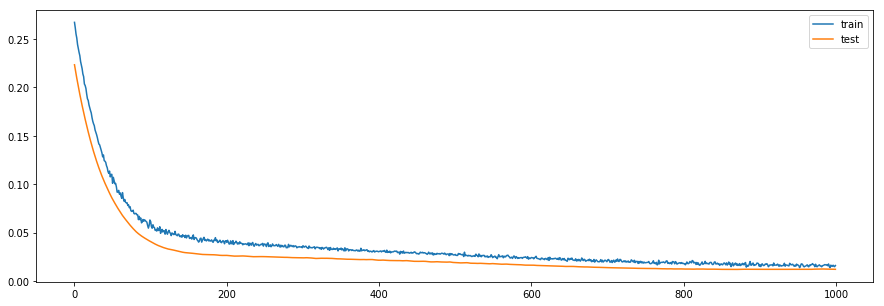

In [11]:
# The design of the network stacks an LSTM (RNN) layer on top of a dropout and a fully connected layers.
# The addition of dropoutlayers in known to help with overfitting problems likethe ones encountered
# during hyperparameter tuning
adam_model = Sequential()
adam_model.add(LSTM(3, input_shape=(in_training_values.shape[1], in_training_values.shape[2])))
adam_model.add(Dropout(0.2))
adam_model.add(Dense(14))

adam_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
# fit network
history = adam_model.fit(in_training_values, out_training_values, epochs=1000, batch_size=int(len(in_training_values)*0.5), validation_data=(in_test_values, out_test_values), verbose=0, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Experiment #3: RMSPROP optimizer

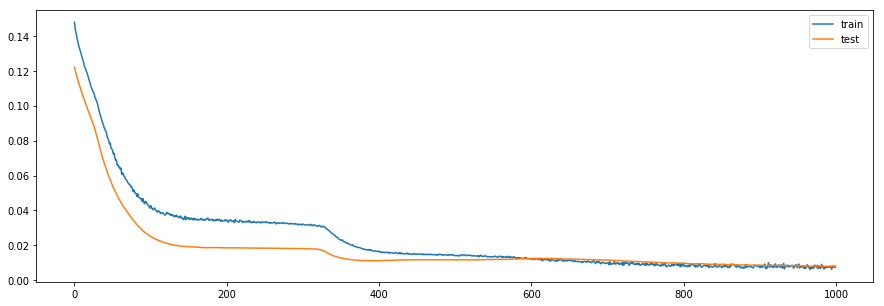

In [30]:
# The design of the network stacks an LSTM (RNN) layer on top of a dropout and a fully connected layers.
# The addition of dropoutlayers in known to help with overfitting problems likethe ones encountered
# during hyperparameter tuning
rmsprop_model = Sequential()
rmsprop_model.add(LSTM(2, input_shape=(in_training_values.shape[1], in_training_values.shape[2])))
rmsprop_model.add(Dropout(0.2))
rmsprop_model.add(Dense(14))

rmsprop_model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop')
# fit network
history = rmsprop_model.fit(in_training_values, out_training_values, epochs=1000, batch_size=int(len(in_training_values)*0.5), validation_data=(in_test_values, out_test_values), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# 3.-Evaluate models and compare

After the models are fit, we can forecast for the test dataset. 

A visualization comparing the test data over our model will help us better understand the differences.


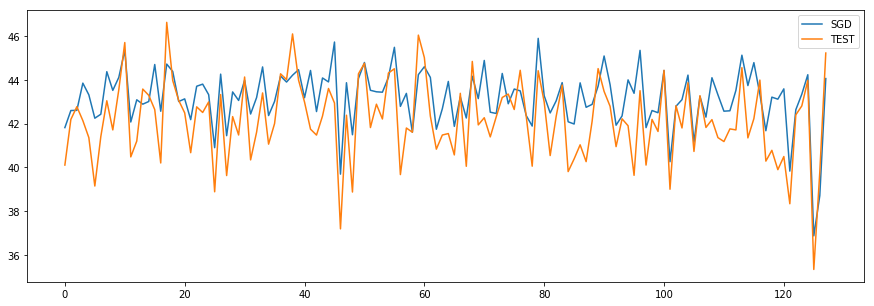

In [31]:
# make a prediction
sgd_yhat = sgd_model.predict(in_test_values)

#invert the normalization to bring it back to its original units
sgd_inv_yhat = scaler.inverse_transform(sgd_yhat)
sgd_inv_yhat = DataFrame(sgd_inv_yhat, columns=out_training_df.columns)

pyplot.plot(sgd_inv_yhat['out10'], label='SGD')
pyplot.plot(out_test_df['out10'], label='TEST')
pyplot.legend()
pyplot.show()

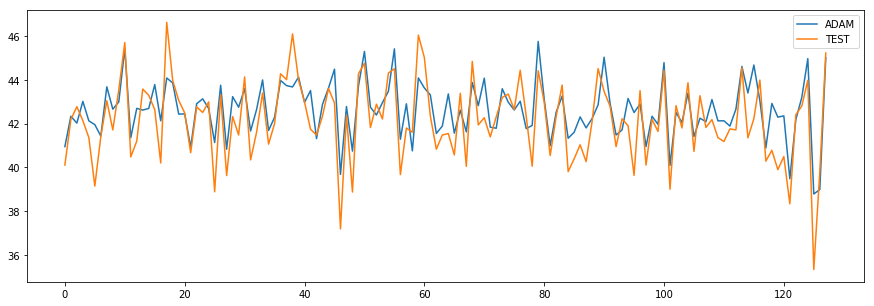

In [32]:
# make a prediction
adam_yhat = adam_model.predict(in_test_values)

#invert the normalization to bring it back to its original units
adam_inv_yhat = scaler.inverse_transform(adam_yhat)
adam_inv_yhat = DataFrame(adam_inv_yhat, columns=out_training_df.columns)

pyplot.plot(adam_inv_yhat['out10'], label='ADAM')
pyplot.plot(out_test_df['out10'], label='TEST')
pyplot.legend()
pyplot.show()

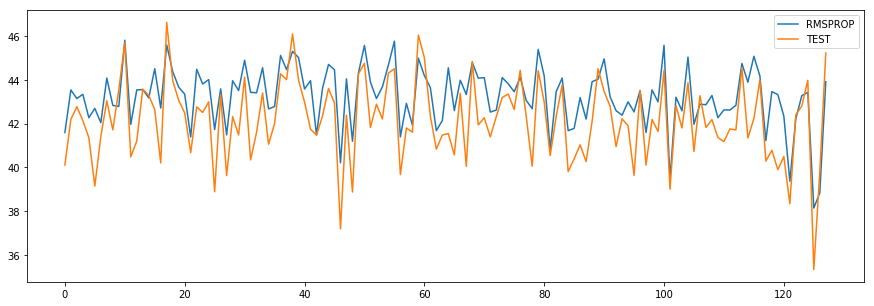

In [33]:
# make a prediction
rmsprop_yhat = rmsprop_model.predict(in_test_values)

#invert the normalization to bring it back to its original units
rmsprop_inv_yhat = scaler.inverse_transform(rmsprop_yhat)
rmsprop_inv_yhat = DataFrame(rmsprop_inv_yhat, columns=out_training_df.columns)

pyplot.plot(rmsprop_inv_yhat['out10'], label='RMSPROP')
pyplot.plot(out_test_df['out10'], label='TEST')
pyplot.legend()
pyplot.show()

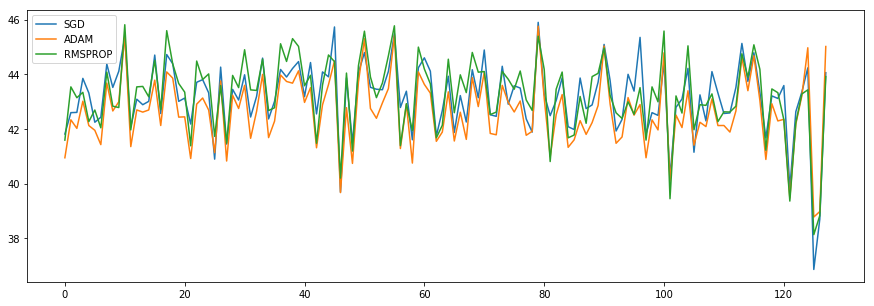

In [34]:
pyplot.plot(sgd_inv_yhat['out10'], label='SGD')
pyplot.plot(adam_inv_yhat['out10'], label='ADAM')
pyplot.plot(rmsprop_inv_yhat['out10'], label='RMSPROP')

pyplot.legend()
pyplot.show()

In [35]:
sgd_loss = sgd_model.evaluate(in_test_values, out_test_values, verbose=0)
adam_loss = adam_model.evaluate(in_test_values, out_test_values, verbose=0)
rmsprop_loss = rmsprop_model.evaluate(in_test_values, out_test_values, verbose=0)

print("SGD:",sgd_loss)
print("ADAM:", adam_loss)
print("RMSPROP:", rmsprop_loss)

SGD: 0.007159236003644764
ADAM: 0.012116840109229088
RMSPROP: 0.008137648343108594


## 4.-Conclusions and future work

The three evaluated optimizers performed very similarly with outputs visibly parallel to each other.
Nevertheless, the comparison against the provided test values show that in general there is a tendency to underestimate the magnitude of outliers (i.e. at t=18, t=45, t=62, t=82, etc.), at least for the observed output feature out10.

From the perspective of the loss function, however, it is fairly remarkable that all three optimizers achieve around 1% (SGD even lower), which can be considered acceptable given the amount of training data fed to the model.

The inclusion of dropout layers has proven to reduce significantly the overfitting problem, and in general terms the learning history curves tend to converge asymptotically.

### Future work:
-Try different hyperparameters

-Implement a rolling time window parser

-Make some further exploration of the features and their values (Pearson, Isolation Forest, Truncated SVD, etc. )

-Try a larger training data set
